<a href="https://colab.research.google.com/github/PCeltide/Python-for-Algorithmic-Trading-Cookbook/blob/main/Chapter%205/3_Fama_MacBeth_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openbb[all]

In [ ]:
from openbb import obb

Extensions to add: alpha_vantage@1.4.1, biztoc@1.4.2, cboe@1.4.1, deribit@1.0.1, ecb@1.4.2, econometrics@1.5.3, federal_reserve@1.4.3, finra@1.4.1, finviz@1.3.1, government_us@1.4.1, multpl@1.1.1, nasdaq@1.4.1, openbb_charting@2.3.4, quantitative@1.4.3, seeking_alpha@1.4.1, stockgrid@1.4.1, technical@1.4.3, tmx@1.3.2, tradier@1.3.1, wsj@1.4.1, yfinance@1.4.6
Extensions to remove: federal_reserve@1.4.2, yfinance@1.4.3

Building...


In [ ]:
obb.user.preferences.output_type = "dataframe"
obb.user.credentials.fmp_api_key = "KYgyiV8I97xGqBeV2HMRc8kzqQxijr45"

In [ ]:
stocks = sorted(['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'NVDA', 'TSLA', 'JPM', 'V', 'JNJ', 'GS', 'LLY', 'XOM', 'WMT', 'PG', 'HD', 'UNH', 'BAC'])
start_date = "2018-01-01"
end_date = "2025-05-01"
historical_price_df = obb.equity.price.historical(symbol = stocks,
                                                  start_date = start_date,
                                                  end_date = end_date,
                                                  provider="fmp")

In [ ]:
historical_price_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33174 entries, 2018-01-02 to 2025-05-01
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   open               33174 non-null  float64
 1   high               33174 non-null  float64
 2   low                33174 non-null  float64
 3   close              33174 non-null  float64
 4   volume             33174 non-null  int64  
 5   vwap               33174 non-null  float64
 6   adj_close          33174 non-null  float64
 7   unadjusted_volume  33174 non-null  float64
 8   change             33174 non-null  float64
 9   change_percent     33174 non-null  float64
 10  symbol             33174 non-null  object 
dtypes: float64(9), int64(1), object(1)
memory usage: 3.0+ MB


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Calculate monthly percentage returns for each stock
historical_price_df.index = pd.to_datetime(historical_price_df.index)
monthly_close_prices_series = historical_price_df.groupby('symbol')['close'].resample('ME').last()
# Now, calculate monthly percentage returns for each stock
monthly_returns_df = monthly_close_prices_series.groupby(level='symbol').pct_change().dropna()
print(monthly_returns_df.head())

symbol  date      
AAPL    2018-02-28    0.063784
        2018-03-31   -0.057938
        2018-04-30   -0.015018
        2018-05-31    0.130687
        2018-06-30   -0.009418
Name: close, dtype: float64


# Fama-MacBeth Regression

The primary goal is to test whether certain factors (characteristics of stocks or broader economic factors) carry a risk premium. In other words, do these factors systematically explain differences in average stock returns?

If a factor does have a premium, it means that, on average, exposure to that factor is associated with higher (or lower) returns.

**The Two-Stage Process:**

The Fama-MacBeth procedure typically involves two stages:

1.  **Stage 1: Time-Series Regressions (Estimating Betas/Exposures)**
  * For *each individual stock* (or portfolio) in your sample, you run a time-series regression of its excess returns against the factor returns.
  * The equation for a single stock $i$ might look like: $$R_{i,t} - R_{f,t} = \alpha_i + \beta_{i,MKT}(R_{MKT,t} - R_{f,t}) +\beta_{i,SMB}SMB_t + \beta_{i,HML}HML_t + ... + \epsilon_{i,t}$$
    Where:
      * $R_{i,t} - R_{f,t}$ is the excess return of stock $i$ at time $t$.
      * $R_{MKT,t} - R_{f,t}$ is the market risk premium at time $t$.
      * $SMB_t$ (Small Minus Big) is the return of a factor-mimicking portfolio for size at time $t$.
      * $HML_t$ (High Minus Low) is the return of a factor-mimicking portfolio for value at time $t$.
      * The $\beta$ coefficients ($\beta_{i,MKT}, \beta_{i,SMB}, \beta_{i,HML}$, etc.) are the **factor loadings** (or exposures) for stock $i$ to each factor. These are estimated for each stock from its own time-series data.

2.  **Stage 2: Cross-Sectional Regressions (Estimating Factor Risk Premia)**
  * For *each time period* (e.g., each month or each day) in your sample, you run a cross-sectional regression.
  * In this regression, the dependent variable is the actual excess returns of all stocks in that specific time period.
  * The independent variables are the factor loadings (the $\beta$s) that you estimated for each stock in Stage 1.
  * The equation for a single time period $t$ might look like: $$R_{i,t} - R_{f,t} = \lambda_{0,t} + \lambda_{MKT,t}\hat{\beta}_{i,MKT} + \lambda_{SMB,t}\hat{\beta}_{i,SMB} + \lambda_{HML,t}\hat{\beta}_{i,HML} + ... + u_{i,t}$$
  Where:
        * $R_{i,t} - R_{f,t}$ is the excess return of stock $i$ at this specific time $t$.
        * $\hat{\beta_{i, MKT}}, \hat{\beta_{i,SMB}}, \hat{\beta_{i,HML}} $ are the factor loadings for stock $i$ (estimated from Stage 1, often using data *prior* to time $t$ to avoid lookahead bias if we are careful).
        * The coefficients of this cross-sectional regression ($\lambda_{MKT,t}, \lambda_{SMB,t}, \lambda_{HML,t}$, etc.) are the **estimates of the risk premia for each factor *at that specific time t***. $\lambda_{0,t}$ is the cross-sectional intercept (average abnormal return not explained by factor exposures at time t).

3.  **Averaging and Testing Lambdas**:
  * After running the cross-sectional regression for every time period, you will have a time series of estimates for each factor premium (e.g., a series of $\lambda_{MKT,t}$ values, a series of $\lambda_{SMB,t}$ values, etc.).
  * The **average** of each of these time series of lambdas (e.g., $\bar{\lambda}_{MKT} = \frac{1}{T}\sum_{t=1}^{T} \lambda_{MKT,t}$) is taken as the overall estimate of the risk premium for that factor.
  * Finally, you perform t-tests on these average lambdas to see if they are statistically significantly different from zero. A significant positive $\bar{\lambda}$ suggests that exposure to that factor has historically been rewarded with higher returns, on average.


In [ ]:
# Let's load the FAMA factors first

import pandas_datareader as pdr

factors_ff3_monthly_raw = pdr.DataReader(
  name="F-F_Research_Data_Factors",
  data_source="famafrench",
  start=start_date,
  end=end_date)[0]

factors_ff3_monthly = (factors_ff3_monthly_raw
  .divide(100)
  .reset_index(names="date")
  .assign(date=lambda x: pd.to_datetime(x["date"].astype(str)))
  .rename(str.lower, axis="columns")
  .rename(columns={"mkt-rf": "mkt_excess"})
)

<ipython-input-143-262230b9eca4>:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors_ff3_monthly_raw = pdr.DataReader(
<ipython-input-143-262230b9eca4>:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors_ff3_monthly_raw = pdr.DataReader(


In [ ]:
factors_ff3_monthly.head(10)

,date,mkt_excess,smb,hml,rf
0,2018-01-01,0.0557,-0.0312,-0.0128,0.0012
1,2018-02-01,-0.0365,0.0026,-0.0104,0.0011
2,2018-03-01,-0.0235,0.0406,-0.0020,0.0011
3,2018-04-01,0.0029,0.0113,0.0054,0.0014
4,2018-05-01,0.0265,0.0526,-0.0322,0.0014
5,2018-06-01,0.0048,0.0114,-0.0233,0.0014
6,2018-07-01,0.0319,-0.0222,0.0045,0.0016
7,2018-08-01,0.0344,0.0115,-0.0400,0.0016
8,2018-09-01,0.0006,-0.0229,-0.0171,0.0015
9,2018-10-01,-0.0768,-0.0474,0.0340,0.0019


In [ ]:
# Let's organize these data by converting the index into the dates

factors_ff3_monthly['date'] = pd.to_datetime(factors_ff3_monthly['date'])
factors_ff3_monthly['date'] = factors_ff3_monthly['date'] + pd.offsets.MonthEnd(0)
factors_ff3_monthly.index = factors_ff3_monthly['date']
factors_ff3_monthly = factors_ff3_monthly.drop('date', axis=1)

factors_ff3_monthly.head(10)

,mkt_excess,smb,hml,rf
date,,,,
2018-01-31,0.0557,-0.0312,-0.0128,0.0012
2018-02-28,-0.0365,0.0026,-0.0104,0.0011
2018-03-31,-0.0235,0.0406,-0.0020,0.0011
2018-04-30,0.0029,0.0113,0.0054,0.0014
2018-05-31,0.0265,0.0526,-0.0322,0.0014
2018-06-30,0.0048,0.0114,-0.0233,0.0014
2018-07-31,0.0319,-0.0222,0.0045,0.0016
2018-08-31,0.0344,0.0115,-0.0400,0.0016
2018-09-30,0.0006,-0.0229,-0.0171,0.0015


In [ ]:
# Create a DataFrame from our previous to have a monthly return for a stock
monthly_returns_pivot_df = monthly_returns_df.unstack(level='symbol')
monthly_returns_pivot_df.head()

symbol,AAPL,AMZN,BAC,GOOG,GS,HD,JNJ,JPM,LLY,META,MSFT,NVDA,PG,TSLA,UNH,V,WMT,XOM
date,,,,,,,,,,,,,,,,,,
2018-02-28,0.063784,0.042459,0.003125,-0.055726,-0.018515,-0.092733,-0.060135,-0.001470,-0.054389,-0.045856,-0.013051,-0.016260,-0.090572,-0.031753,-0.044852,-0.010384,-0.155643,-0.132417
2018-03-31,-0.057938,-0.042978,-0.065732,-0.066075,-0.042102,-0.022110,-0.013320,-0.047879,0.004544,-0.103914,-0.026661,-0.042975,0.009679,-0.224311,-0.053767,-0.027005,-0.011333,-0.014919
2018-04-30,-0.015018,0.082078,-0.002334,-0.013956,-0.053720,0.036804,-0.012954,-0.010821,0.047822,0.076413,0.024652,-0.029361,-0.087538,0.104284,0.104673,0.060692,-0.005732,0.042086
2018-05-31,0.130687,0.040480,-0.029412,0.066444,-0.052238,0.009470,-0.054313,-0.016271,0.048970,0.115000,0.056886,0.120996,0.011474,-0.031138,0.021616,0.030265,-0.067141,0.044887
2018-06-30,-0.009418,0.043078,-0.029270,0.028203,-0.023508,0.045832,0.014379,-0.026259,0.003410,0.013244,-0.002327,-0.060317,0.066831,0.204426,0.015859,0.013234,0.037804,0.018341


In [ ]:
factors_ff3_monthly_return = monthly_returns_pivot_df.merge(factors_ff3_monthly, left_index=True, right_index=True)

In [ ]:
factors_ff3_monthly_return.head()

,AAPL,AMZN,BAC,GOOG,GS,HD,JNJ,JPM,LLY,META,...,PG,TSLA,UNH,V,WMT,XOM,mkt_excess,smb,hml,rf
date,,,,,,,,,,,,,,,,,,,,,
2018-02-28,0.063784,0.042459,0.003125,-0.055726,-0.018515,-0.092733,-0.060135,-0.001470,-0.054389,-0.045856,...,-0.090572,-0.031753,-0.044852,-0.010384,-0.155643,-0.132417,-0.0365,0.0026,-0.0104,0.0011
2018-03-31,-0.057938,-0.042978,-0.065732,-0.066075,-0.042102,-0.022110,-0.013320,-0.047879,0.004544,-0.103914,...,0.009679,-0.224311,-0.053767,-0.027005,-0.011333,-0.014919,-0.0235,0.0406,-0.0020,0.0011
2018-04-30,-0.015018,0.082078,-0.002334,-0.013956,-0.053720,0.036804,-0.012954,-0.010821,0.047822,0.076413,...,-0.087538,0.104284,0.104673,0.060692,-0.005732,0.042086,0.0029,0.0113,0.0054,0.0014
2018-05-31,0.130687,0.040480,-0.029412,0.066444,-0.052238,0.009470,-0.054313,-0.016271,0.048970,0.115000,...,0.011474,-0.031138,0.021616,0.030265,-0.067141,0.044887,0.0265,0.0526,-0.0322,0.0014
2018-06-30,-0.009418,0.043078,-0.029270,0.028203,-0.023508,0.045832,0.014379,-0.026259,0.003410,0.013244,...,0.066831,0.204426,0.015859,0.013234,0.037804,0.018341,0.0048,0.0114,-0.0233,0.0014


In [ ]:
# Calculate the excess returns
stock_columns = factors_ff3_monthly_return[stocks]
excess_returns = stock_columns.subtract(factors_ff3_monthly_return['rf'], axis=0)
excess_returns.columns = [f'{col}_excess' for col in stocks]
factors_ff3_monthly_return = pd.concat([factors_ff3_monthly_return, excess_returns], axis=1)
factors_ff3_monthly_return.head()

,AAPL,AMZN,BAC,GOOG,GS,HD,JNJ,JPM,LLY,META,...,LLY_excess,META_excess,MSFT_excess,NVDA_excess,PG_excess,TSLA_excess,UNH_excess,V_excess,WMT_excess,XOM_excess
date,,,,,,,,,,,,,,,,,,,,,
2018-02-28,0.063784,0.042459,0.003125,-0.055726,-0.018515,-0.092733,-0.060135,-0.001470,-0.054389,-0.045856,...,-0.055489,-0.046956,-0.014151,-0.017360,-0.091672,-0.032853,-0.045952,-0.011484,-0.156743,-0.133517
2018-03-31,-0.057938,-0.042978,-0.065732,-0.066075,-0.042102,-0.022110,-0.013320,-0.047879,0.004544,-0.103914,...,0.003444,-0.105014,-0.027761,-0.044075,0.008579,-0.225411,-0.054867,-0.028105,-0.012433,-0.016019
2018-04-30,-0.015018,0.082078,-0.002334,-0.013956,-0.053720,0.036804,-0.012954,-0.010821,0.047822,0.076413,...,0.046422,0.075013,0.023252,-0.030761,-0.088938,0.102884,0.103273,0.059292,-0.007132,0.040686
2018-05-31,0.130687,0.040480,-0.029412,0.066444,-0.052238,0.009470,-0.054313,-0.016271,0.048970,0.115000,...,0.047570,0.113600,0.055486,0.119596,0.010074,-0.032538,0.020216,0.028865,-0.068541,0.043487
2018-06-30,-0.009418,0.043078,-0.029270,0.028203,-0.023508,0.045832,0.014379,-0.026259,0.003410,0.013244,...,0.002010,0.011844,-0.003727,-0.061717,0.065431,0.203026,0.014459,0.011834,0.036404,0.016941


In [ ]:
import statsmodels.api as sm

In [ ]:
# Run the first regression
X = factors_ff3_monthly_return[['mkt_excess', 'smb', 'hml']].copy()
X_const = sm.add_constant(X)

betas = {}

for stock in stocks:
  Y = factors_ff3_monthly_return[f'{stock}_excess']
  model = sm.OLS(Y, X_const)
  results = model.fit()
  desired_coeffs = ['mkt_excess', 'smb', 'hml']
  factor_coefficients = results.params[desired_coeffs]
  betas[stock] = factor_coefficients

#print(betas)

In [ ]:
# Convert back to a DataFrame
betas_df = pd.DataFrame(betas)
betas_df.index = [f'beta_{s}' for s in betas_df.index]
betas_df.head()

,AAPL,AMZN,BAC,GOOG,GS,HD,JNJ,JPM,LLY,META,MSFT,NVDA,PG,TSLA,UNH,V,WMT,XOM
beta_mkt_excess,1.217517,1.201086,1.304265,1.007214,1.264774,1.001081,0.578180,1.038545,0.452222,1.279407,0.972246,1.819089,0.521311,1.867488,0.613189,0.938758,0.594732,0.897734
beta_smb,-0.139651,0.019335,0.076209,-0.344855,0.299053,-0.121314,-0.332190,0.083064,-0.412060,-0.561652,-0.512890,-0.335310,-0.773096,1.067425,-0.088453,-0.351406,-0.485852,-0.026022
beta_hml,-0.493397,-0.914520,0.939122,-0.239911,0.605113,0.076564,0.199252,0.800157,-0.456379,-0.571185,-0.493736,-1.162919,0.106030,-1.131564,0.135738,0.034897,-0.144609,1.090103


In [ ]:
# Run the cross-sectional regression
excess_returns_names = [f'{col}_excess' for col in stocks]
X_t = betas_df.transpose()
X_t_with_const = sm.add_constant(X_t)
coefs = ['const', 'beta_mkt_excess', 'beta_smb', 'beta_hml']
lambda_t = {}
constants = {}
for t in range(len(factors_ff3_monthly_return.index)):
  Y_t = factors_ff3_monthly_return[excess_returns_names].iloc[t]
  Y_t.index = stocks
  #print(Y_t)
  #print(f"The shape of Y_t is {Y_t.shape} and the shape of X_t is {X_t.shape}")
  model_t = sm.OLS(Y_t, X_t_with_const)
  results = model_t.fit()
  lambda_coefficients = results.params[coefs]
  lambda_t[factors_ff3_monthly_return.index[t]] = lambda_coefficients

In [ ]:
lambda_t = pd.DataFrame(lambda_t).transpose()
lambda_t.columns = ['lambda_0', 'lambda_mkt_excess','lambda_smb', 'lambda_hml']
lambda_t.head()

,lambda_0,lambda_mkt_excess,lambda_smb,lambda_hml
2018-02-28,-0.100281,0.057289,0.002697,-0.009256
2018-03-31,-0.021241,-0.035708,-0.072054,0.021605
2018-04-30,0.083206,-0.054157,0.078138,-0.037318
2018-05-31,-0.082618,0.084856,-0.101438,-0.021404
2018-06-30,0.116675,-0.081870,0.111826,-0.047584


In [ ]:
lambda_t.dropna() # Just in case
mean = {}
std = {}
t_stat = {}
p_values = {}
for l in lambda_t.columns:
  mean[l] = lambda_t[l].mean()
  std[l] = lambda_t[l].std()/math.sqrt(len(lambda_t[l]))
  t_stat[l] = mean[l]/std[l]
  p_values[l] = stats.t.sf(abs(t_stat[l]), df=len(lambda_t[l]) - 1) * 2 * 100

stats_df = pd.DataFrame([mean, std, t_stat, p_values])
stats_df.index = ['Average Lambda', 'Std Error', 'T-statistic', 'P-value (%)']
stats_df.head(4)

,lambda_0,lambda_mkt_excess,lambda_smb,lambda_hml
Average Lambda,0.006894,0.009171,0.007239,-0.013661
Std Error,0.011102,0.011082,0.011469,0.006144
T-statistic,0.620914,0.827505,0.631159,-2.223498
P-value (%),53.637847,41.035274,52.969199,2.893302


What we see is the only notable statistic that we can derive from our analysis is regarding the High Minus Low factor; it indicates that there are many growth stocks in this portfolio (this makes sense; all the stocks in the magnificent seven have a high p/e ratio, especially TSLA and create a significant amount of the return we see in the portfolio). In general, a negative $\lambda_{hml}$ indicates a portfolio's returns dependency on growth stocks. A statistically significant negative suggests that for the chosen portfolio and period, stocks with growth characteristics (lower HML betas) significantly outperformed those with value characteristics (higher HML betas).

# Momentum

While not traditionally a factor in the Fama-French factors, Momentum has been a strong performer over the past few years; let's see if we can spot this factor in our portfolio.

In [ ]:
factors_ff3_monthly_mom_raw = pdr.DataReader(
  name="F-F_Momentum_Factor",
  data_source="famafrench",
  start=start_date,
  end=end_date)[0]

factors_ff3_monthly_mom = (factors_ff3_monthly_mom_raw
  .divide(100)
  .reset_index(names="date")
  .assign(date=lambda x: pd.to_datetime(x["date"].astype(str)))
  .rename(str.lower, axis="columns")
)

<ipython-input-156-088dd7a16b3f>:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors_ff3_monthly_mom_raw = pdr.DataReader(
<ipython-input-156-088dd7a16b3f>:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors_ff3_monthly_mom_raw = pdr.DataReader(


In [ ]:
factors_ff3_monthly_mom.head()

,date,mom
0,2018-01-01,0.0405
1,2018-02-01,0.0355
2,2018-03-01,-0.0113
3,2018-04-01,0.0037
4,2018-05-01,0.0387


In [ ]:
# Let's combine this with the earlier data

factors_ff3_monthly_mom['date'] = pd.to_datetime(factors_ff3_monthly_mom['date'])
factors_ff3_monthly_mom['date'] = factors_ff3_monthly_mom['date'] + pd.offsets.MonthEnd(0)
factors_ff3_monthly_mom.index = factors_ff3_monthly_mom['date']
factors_ff3_monthly_mom = factors_ff3_monthly_mom.drop('date', axis=1)

cols = factors_ff3_monthly.columns.tolist()
insertion_index = cols.index('hml') + 1
factors_merged = pd.concat([factors_ff3_monthly[cols[:insertion_index]], factors_ff3_monthly_mom, factors_ff3_monthly[cols[insertion_index:]]], axis=1)
factors_merged.head()

,mkt_excess,smb,hml,mom,rf
date,,,,,
2018-01-31,0.0557,-0.0312,-0.0128,0.0405,0.0012
2018-02-28,-0.0365,0.0026,-0.0104,0.0355,0.0011
2018-03-31,-0.0235,0.0406,-0.0020,-0.0113,0.0011
2018-04-30,0.0029,0.0113,0.0054,0.0037,0.0014
2018-05-31,0.0265,0.0526,-0.0322,0.0387,0.0014


In [ ]:
# Now we can run our regression

factors_ff4_monthly_return = monthly_returns_pivot_df.merge(factors_merged, left_index=True, right_index=True)
factors_ff4_monthly_return.head()

,AAPL,AMZN,BAC,GOOG,GS,HD,JNJ,JPM,LLY,META,...,TSLA,UNH,V,WMT,XOM,mkt_excess,smb,hml,mom,rf
date,,,,,,,,,,,,,,,,,,,,,
2018-02-28,0.063784,0.042459,0.003125,-0.055726,-0.018515,-0.092733,-0.060135,-0.001470,-0.054389,-0.045856,...,-0.031753,-0.044852,-0.010384,-0.155643,-0.132417,-0.0365,0.0026,-0.0104,0.0355,0.0011
2018-03-31,-0.057938,-0.042978,-0.065732,-0.066075,-0.042102,-0.022110,-0.013320,-0.047879,0.004544,-0.103914,...,-0.224311,-0.053767,-0.027005,-0.011333,-0.014919,-0.0235,0.0406,-0.0020,-0.0113,0.0011
2018-04-30,-0.015018,0.082078,-0.002334,-0.013956,-0.053720,0.036804,-0.012954,-0.010821,0.047822,0.076413,...,0.104284,0.104673,0.060692,-0.005732,0.042086,0.0029,0.0113,0.0054,0.0037,0.0014
2018-05-31,0.130687,0.040480,-0.029412,0.066444,-0.052238,0.009470,-0.054313,-0.016271,0.048970,0.115000,...,-0.031138,0.021616,0.030265,-0.067141,0.044887,0.0265,0.0526,-0.0322,0.0387,0.0014
2018-06-30,-0.009418,0.043078,-0.029270,0.028203,-0.023508,0.045832,0.014379,-0.026259,0.003410,0.013244,...,0.204426,0.015859,0.013234,0.037804,0.018341,0.0048,0.0114,-0.0233,-0.0236,0.0014


In [ ]:
# Calculate the excess returns
stock_columns = factors_ff4_monthly_return[stocks]
excess_returns = stock_columns.subtract(factors_ff4_monthly_return['rf'], axis=0)
excess_returns.columns = [f'{col}_excess' for col in stocks]
factors_ff4_monthly_return = pd.concat([factors_ff4_monthly_return, excess_returns], axis=1)
factors_ff4_monthly_return.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83 entries, 2018-02-28 to 2024-12-31
Data columns (total 41 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AAPL         83 non-null     float64
 1   AMZN         83 non-null     float64
 2   BAC          83 non-null     float64
 3   GOOG         83 non-null     float64
 4   GS           83 non-null     float64
 5   HD           83 non-null     float64
 6   JNJ          83 non-null     float64
 7   JPM          83 non-null     float64
 8   LLY          83 non-null     float64
 9   META         83 non-null     float64
 10  MSFT         83 non-null     float64
 11  NVDA         83 non-null     float64
 12  PG           83 non-null     float64
 13  TSLA         83 non-null     float64
 14  UNH          83 non-null     float64
 15  V            83 non-null     float64
 16  WMT          83 non-null     float64
 17  XOM          83 non-null     float64
 18  mkt_excess   83 non-null     flo

In [ ]:
factors_ff4_monthly_return.columns = factors_ff4_monthly_return.columns.str.strip()

In [ ]:
# Regression Steps
X = factors_ff4_monthly_return[['mkt_excess', 'smb', 'hml', 'mom']].copy()
X_const = sm.add_constant(X)

betas = {}

for stock in stocks:
  Y = factors_ff4_monthly_return[f'{stock}_excess']
  model = sm.OLS(Y, X_const)
  results = model.fit()
  desired_coeffs = ['mkt_excess', 'smb', 'hml', 'mom']
  #print(results.summary())
  factor_coefficients = results.params[desired_coeffs]
  betas[stock] = factor_coefficients

betas_df = pd.DataFrame(betas)
betas_df.index = [f'beta_{s}' for s in betas_df.index]


excess_returns_names = [f'{col}_excess' for col in stocks]
X_t = betas_df.transpose()
X_t_with_const = sm.add_constant(X_t)
coefs = ['const', 'beta_mkt_excess', 'beta_smb', 'beta_hml', 'beta_mom']
lambda_t = {}
constants = {}
for t in range(len(factors_ff4_monthly_return.index)):
  Y_t = factors_ff4_monthly_return[excess_returns_names].iloc[t]
  Y_t.index = stocks
  model_t = sm.OLS(Y_t, X_t_with_const)
  results = model_t.fit()
  lambda_coefficients = results.params[coefs]
  lambda_t[factors_ff4_monthly_return.index[t]] = lambda_coefficients

lambda_t = pd.DataFrame(lambda_t).transpose()
lambda_t.columns = ['lambda_0', 'lambda_mkt_excess','lambda_smb', 'lambda_hml', 'lambda_mom']
lambda_t.head()

,lambda_0,lambda_mkt_excess,lambda_smb,lambda_hml,lambda_mom
2018-02-28,-0.117989,0.075279,-0.000764,-0.008796,0.022412
2018-03-31,-0.057711,0.001344,-0.079183,0.022552,0.104669
2018-04-30,0.107075,-0.078407,0.082803,-0.037938,-0.052472
2018-05-31,-0.087789,0.090110,-0.102449,-0.021270,0.026634
2018-06-30,0.157262,-0.123103,0.119760,-0.048638,-0.088594


In [ ]:
from scipy import stats # Import the stats module from scipy

In [ ]:
lambda_t.dropna() # Just in case
mean = {}
std = {}
t_stat = {}
p_values = {}
for l in lambda_t.columns:
  mean[l] = lambda_t[l].mean()
  std[l] = lambda_t[l].std()/math.sqrt(len(lambda_t[l]))
  t_stat[l] = mean[l]/std[l]
  p_values[l] = stats.t.sf(abs(t_stat[l]), df=len(lambda_t[l]) - 1) * 2 * 100

stats_4_df = pd.DataFrame([mean, std, t_stat, p_values])
stats_4_df.index = ['Average Lambda', 'Std Error', 'T-statistic', 'P-value (%)']
stats_4_df.head(4)

,lambda_0,lambda_mkt_excess,lambda_smb,lambda_hml,lambda_mom
Average Lambda,0.002056,0.014085,0.006293,-0.013535,0.008266
Std Error,0.012046,0.011803,0.011705,0.006163,0.009429
T-statistic,0.170694,1.193296,0.537664,-2.196207,0.876736
P-value (%),86.488481,23.619453,59.226494,3.090117,38.319153


In [ ]:
# To compare
stats_df.head()

,lambda_0,lambda_mkt_excess,lambda_smb,lambda_hml
Average Lambda,0.006894,0.009171,0.007239,-0.013661
Std Error,0.011102,0.011082,0.011469,0.006144
T-statistic,0.620914,0.827505,0.631159,-2.223498
P-value (%),53.637847,41.035274,52.969199,2.893302


Summary of My Observations on Your 4-Factor Model:

* **HML Robustness**: The significant negative HML premium remains strong, indicating a persistent growth-over-value effect for your portfolio during this period, independent of momentum.
* **Momentum's Modest Role**: Momentum itself doesn't show a significant premium on average for this portfolio and period.
* **Market Factor Clarification**: Adding Momentum appears to have "cleaned up" the market factor's estimated premium, making it larger and slightly more (though still not decisively) significant.
* **Alpha Reduction**: The model alpha, i.e. $\lambda_0$, decreased and became even less significant, suggesting the 4-factor model does a slightly better job of explaining returns than the 3-factor model, with Momentum absorbing some of what was previously unexplained.


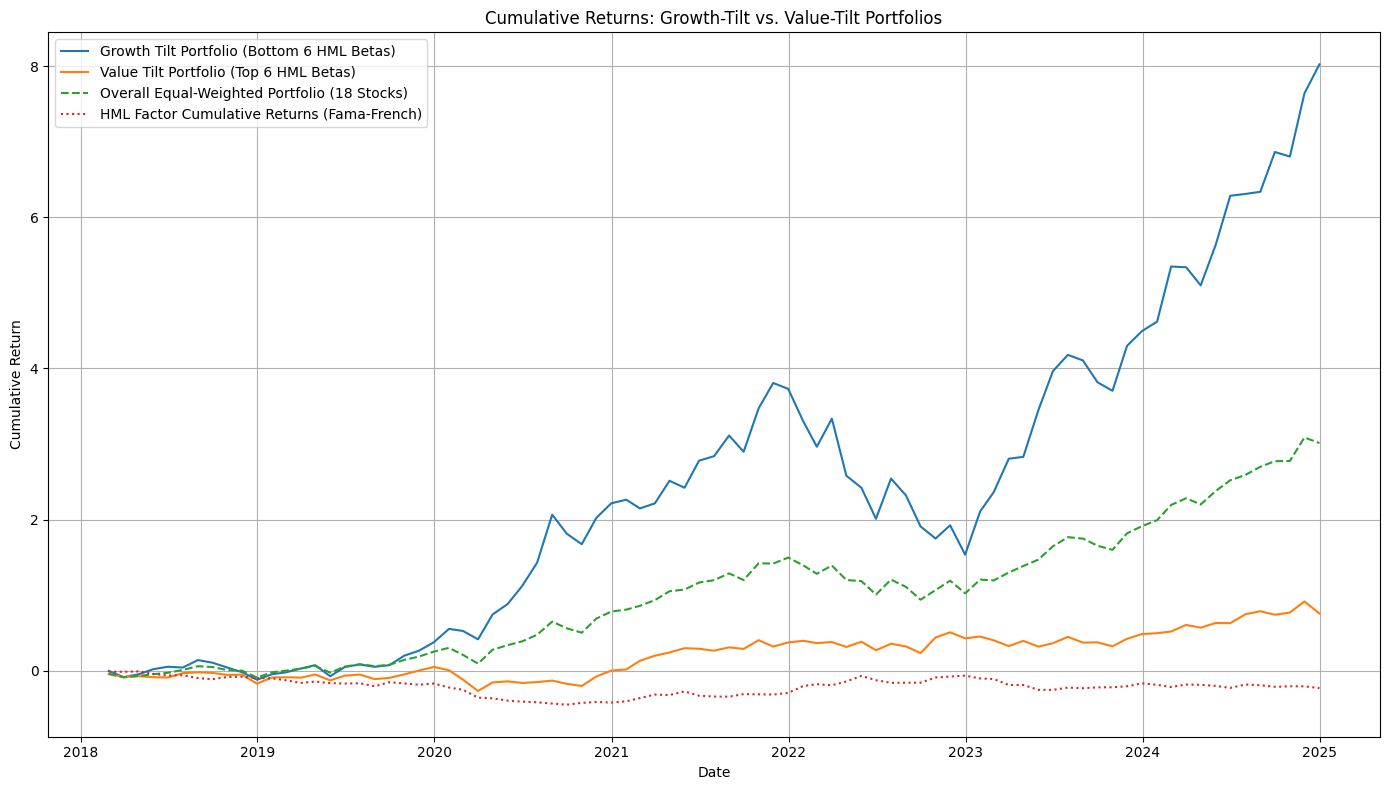

In [ ]:
# HML Factor Tilt Visualization
hml_betas = betas_df.loc['beta_hml'].sort_values()

# Define the number of stocks for top/bottom portfolios (e.g., terciles for 18 stocks = 6 stocks each)
n_portfolio = 6
lowest_hml_stocks = hml_betas.head(n_portfolio).index.tolist()
highest_hml_stocks = hml_betas.tail(n_portfolio).index.tolist()

# Calculate returns for these portfolios
aligned_monthly_returns = monthly_returns_pivot_df.loc[factors_ff4_monthly_return.index]
growth_tilt_returns = aligned_monthly_returns[lowest_hml_stocks].mean(axis=1)
value_tilt_returns = aligned_monthly_returns[highest_hml_stocks].mean(axis=1)
overall_portfolio_returns = aligned_monthly_returns[stocks].mean(axis=1) # Equal-weighted of all 18

# Calculate cumulative returns
cumulative_growth_tilt = (1 + growth_tilt_returns).cumprod() - 1
cumulative_value_tilt = (1 + value_tilt_returns).cumprod() - 1
cumulative_overall_portfolio = (1 + overall_portfolio_returns).cumprod() - 1

# Get the HML factor returns for comparison
hml_factor_returns = factors_ff4_monthly_return['hml']
cumulative_hml_factor = (1 + hml_factor_returns).cumprod() - 1

# Plotting HML-Tilt
plt.figure(figsize=(14, 8))
plt.plot(cumulative_growth_tilt.index, cumulative_growth_tilt, label=f'Growth Tilt Portfolio (Bottom {n_portfolio} HML Betas)')
plt.plot(cumulative_value_tilt.index, cumulative_value_tilt, label=f'Value Tilt Portfolio (Top {n_portfolio} HML Betas)')
plt.plot(cumulative_overall_portfolio.index, cumulative_overall_portfolio, label='Overall Equal-Weighted Portfolio (18 Stocks)', linestyle='--')
plt.plot(cumulative_hml_factor.index, cumulative_hml_factor, label='HML Factor Cumulative Returns (Fama-French)', linestyle=':')

plt.title('Cumulative Returns: Growth-Tilt vs. Value-Tilt Portfolios')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent label overlapping
plt.show()

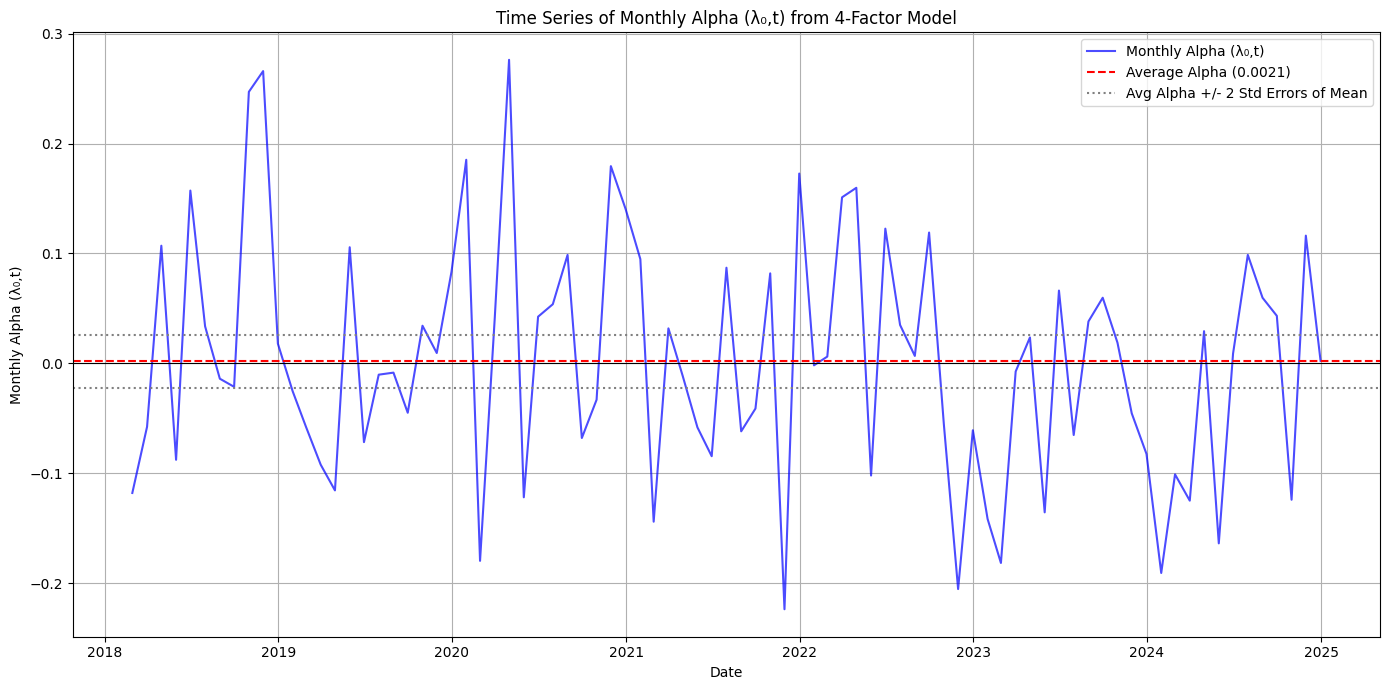


Periods with Monthly Alpha > 2 Series Std Devs from Avg Alpha:
2018-10-31    0.247125
2018-11-30    0.266008
2020-04-30    0.276285
2021-11-30   -0.223822
Name: lambda_0, dtype: float64


In [ ]:
# Alpha (λ₀,t) Time Series Visualization

lambda_0_series = lambda_t['lambda_0']
lambda_0_mean = lambda_0_series.mean()
lambda_0_std_err_of_mean = stats_4_df.loc['Std Error', 'lambda_0']



plt.figure(figsize=(14, 7))
plt.plot(lambda_0_series.index, lambda_0_series, label='Monthly Alpha (λ₀,t)', color='blue', alpha=0.7)
plt.axhline(lambda_0_mean, color='red', linestyle='--', label=f'Average Alpha ({lambda_0_mean:.4f})')
plt.axhline(0, color='black', linestyle='-', linewidth=0.8) # Zero line for reference

# Bands using the standard error of the mean of lambda_0 estimates
plt.axhline(lambda_0_mean + 2 * lambda_0_std_err_of_mean, color='gray', linestyle=':', label=f'Avg Alpha +/- 2 Std Errors of Mean')
plt.axhline(lambda_0_mean - 2 * lambda_0_std_err_of_mean, color='gray', linestyle=':')

plt.title('Time Series of Monthly Alpha (λ₀,t) from 4-Factor Model')
plt.xlabel('Date')
plt.ylabel('Monthly Alpha (λ₀,t)')
plt.legend()
plt.grid(True)
plt.tight_layout() # Adjust layout
plt.show()

# Periods where alpha was particularly high or low
significant_alpha_periods = lambda_0_series[np.abs(lambda_0_series - lambda_0_mean) > 2 * lambda_0_series.std()]
print("\nPeriods with Monthly Alpha > 2 Series Std Devs from Avg Alpha:")
print(significant_alpha_periods)